In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import datetime
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import matplotlib.pyplot as plt
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
from keras.layers import Bidirectional
tf.random.set_seed(1)
np.random.seed(1)
import warnings
warnings.filterwarnings("ignore")

In [38]:
df = pd.read_csv("/content/drive/MyDrive/colab/account_data.csv",parse_dates = True)

In [61]:
a = list(df['accountId'].unique())
df = df[df['accountId']=="5ffdb895b08512986422b08c"]
df=df.copy()
df.date = pd.to_datetime(df.date)
df.sort_values(by="date", inplace=True, ignore_index=True)
account_data = df

In [62]:
keyword_ids = account_data["keywordId"].unique()
keywordwise_sales = account_data.groupby("keywordId")["sales"].sum()
nonzero_sales_keywords = keywordwise_sales[keywordwise_sales>0]
nonzero_sales_keywords.sort_values(ascending=False, inplace=True)
keywords_req = list(nonzero_sales_keywords.index)
keyword_ids = keywords_req[:40]
account_data =  account_data[account_data['keywordId'].isin(keyword_ids)]

In [63]:
account_data.reset_index(inplace = True)
account_data.sort_values(by="date", inplace=True, ignore_index=True)
account_data.drop(columns = "index",inplace = True)
account_data.sort_values(by = 'date',inplace = True)
account_data.reset_index(inplace = True)
account_data.drop(columns = "index",inplace = True)
account_data['clicks'] = account_data["clicks"].astype("int64")
account_data['impressions'] = account_data["impressions"].astype("int64")
account_data['orders'] = account_data["orders"].astype("int64")
account_data["keywordId"] = account_data["keywordId"].astype(str)
account_data["cpc"] = account_data["spend"]/account_data["clicks"] 
account_data["cpc"].interpolate("linear", inplace=True)

In [64]:
account_data.set_index('date',inplace = True)

In [65]:
account_data = account_data[account_data['sales']>100] 
account_data = account_data[account_data['sales']<55000]

In [66]:
validate = account_data[['sales','spend', 'clicks', 'impressions', 'orders','keywordId']].tail(800)
account_data.drop(account_data.tail(800).index,inplace=True)

In [67]:
x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
dataX = x_scaler.fit_transform(account_data[['sales','spend', 'clicks', 'impressions', 'orders']])
dataY = y_scaler.fit_transform(account_data[['sales']])

In [68]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [69]:
account_data.shape

(11101, 10)

In [70]:
hist_window = 800
horizon = 800
TRAIN_SPLIT = 8000
x_train_multi, y_train_multi = custom_ts_multi_data_prep(
    dataX, dataY, 0, TRAIN_SPLIT, hist_window, horizon)
x_val_multi, y_val_multi= custom_ts_multi_data_prep(
    dataX, dataY, TRAIN_SPLIT, None, hist_window, horizon)

In [71]:
print ('Single window of past history')
print(x_train_multi[0])
print(len(x_train_multi[0]))
print('\n Target horizon')
print(y_train_multi[0])
print(len(y_train_multi[0]))

Single window of past history
[[0.07212639 0.01073664 0.07632094 0.00516554 0.09756098]
 [0.04632252 0.1472533  0.18786693 0.06264272 0.07317073]
 [0.15999323 0.02302887 0.23483366 0.00892733 0.31707317]
 ...
 [0.10986276 0.01062101 0.04500978 0.00047593 0.04878049]
 [0.09190872 0.04862038 0.15068493 0.02234716 0.02439024]
 [0.29291132 0.15391934 0.36399217 0.04311269 0.29268293]]
800

 Target horizon
[[6.10970497e-02]
 [6.34125225e-03]
 [1.62781415e-01]
 [6.95298819e-02]
 [2.52570580e-01]
 [3.31857454e-01]
 [8.89077304e-02]
 [3.21619863e-02]
 [7.88031709e-02]
 [4.22749390e-01]
 [8.80117913e-02]
 [1.38623635e-01]
 [1.52936290e-01]
 [1.07032248e-01]
 [9.11536988e-03]
 [2.81946026e-01]
 [1.99665365e-03]
 [3.20727466e-02]
 [1.40936617e-01]
 [3.83701986e-02]
 [6.05258434e-01]
 [1.02572270e-01]
 [1.96600568e-02]
 [1.62887059e-01]
 [8.42255458e-02]
 [8.54645871e-02]
 [3.93713258e-01]
 [4.80520215e-02]
 [7.92365069e-02]
 [5.57398396e-02]
 [3.21311846e-01]
 [9.93947127e-02]
 [5.23608398e-03]
 

In [72]:
BATCH_SIZE = 256
BUFFER_SIZE = 150

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [73]:
ED_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=x_train_multi.shape[-2:], return_sequences=True),
    tf.keras.layers.LSTM(units=32,return_sequences=True),
    tf.keras.layers.LSTM(units=32,return_sequences=True),
    tf.keras.layers.LSTM(units=16,return_sequences=True),
    tf.keras.layers.Dense(units=1)
])
ED_lstm_model.compile(optimizer='adam', loss='mse')

In [74]:
model_path = 'Encoder_Decoder_LSTM_Multivariate_sales_only_LSTM.h5'
EVALUATION_INTERVAL = 10
EPOCHS = 40
history = ED_lstm_model.fit(train_data_multi, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_data_multi, validation_steps=50,verbose =1,
                              callbacks =[
                                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),
                                  tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)
                              ]
                           )

Epoch 1/40
10/10 [==============================] - 12s 593ms/step - loss: 0.0162 - val_loss: 0.0191
Epoch 2/40
10/10 [==============================] - 3s 369ms/step - loss: 0.0245 - val_loss: 0.0185
Epoch 3/40
10/10 [==============================] - 3s 351ms/step - loss: 0.0211 - val_loss: 0.0170
Epoch 4/40
10/10 [==============================] - 4s 382ms/step - loss: 0.0125 - val_loss: 0.0168
Epoch 5/40
10/10 [==============================] - 3s 354ms/step - loss: 0.0235 - val_loss: 0.0176
Epoch 6/40
10/10 [==============================] - 3s 348ms/step - loss: 0.0193 - val_loss: 0.0173
Epoch 7/40
10/10 [==============================] - 3s 353ms/step - loss: 0.0124 - val_loss: 0.0169
Epoch 8/40
10/10 [==============================] - 3s 376ms/step - loss: 0.0247 - val_loss: 0.0174
Epoch 9/40
10/10 [==============================] - 3s 361ms/step - loss: 0.0184 - val_loss: 0.0177
Epoch 10/40
10/10 [==============================] - 3s 354ms/step - loss: 0.0123 - val_loss: 0.017

In [75]:
Trained_model = tf.keras.models.load_model("/content/Encoder_Decoder_LSTM_Multivariate_sales_only_LSTM.h5")

In [76]:
Trained_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 800, 64)           17920     
                                                                 
 lstm_8 (LSTM)               (None, 800, 32)           12416     
                                                                 
 lstm_9 (LSTM)               (None, 800, 32)           8320      
                                                                 
 lstm_10 (LSTM)              (None, 800, 16)           3136      
                                                                 
 dense_2 (Dense)             (None, 800, 1)            17        
                                                                 
Total params: 41,809
Trainable params: 41,809
Non-trainable params: 0
_________________________________________________________________


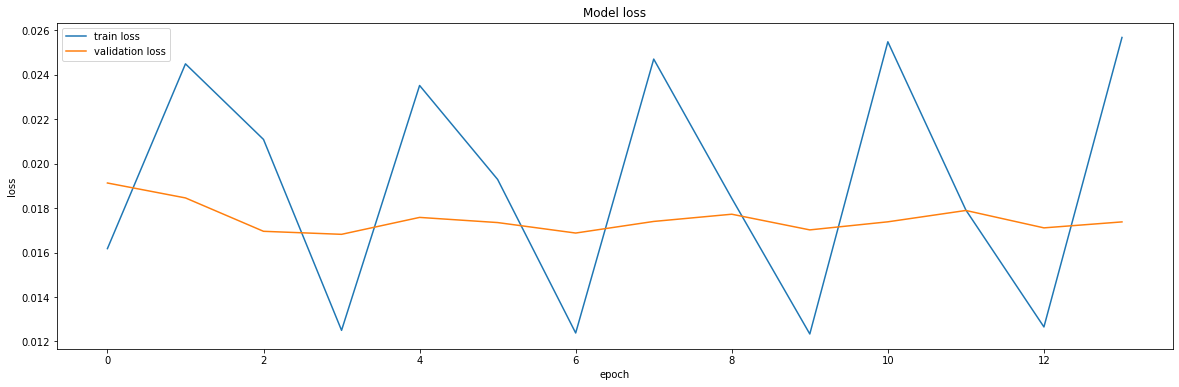

In [79]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [20,6]
plt.show()

In [80]:
data_val = x_scaler.fit_transform(account_data[['sales','spend','orders','clicks','impressions']].tail(800))
print(data_val)
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print(data_val.shape)
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])
print(val_rescaled)
print(val_rescaled.shape)
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
Predicted_results = Trained_model.predict(val_rescaled)
print(Predicted_results)
print(len(Predicted_results))
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results.reshape(-1,1))
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print(Predicted_results_Inv_trans)
print(len(Predicted_results_Inv_trans))

[[0.0246873  0.04920999 0.         0.05324074 0.10345244]
 [0.22354329 0.06898043 0.125      0.11574074 0.08117347]
 [0.07563934 0.11419281 0.08333333 0.09490741 0.15774234]
 ...
 [0.13976516 0.16906374 0.04166667 0.10416667 0.29654354]
 [0.71983409 0.77685637 0.25       0.87268519 0.9192689 ]
 [0.12029597 0.06124818 0.08333333 0.05787037 0.12480647]]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
(800, 5)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
[[[0.0246873  0.04920999 0.         0.05324074 0.10345244]
  [0.22354329 0.06898043 0.125      0.11574074 0.08117347]
  [0.07563934 0.11419281 0.08333333 0.09490741 0.15774234]
  ...
  [0.13976516 0.16906374 0.04166667 0.10416667 0.29654354]
  [0.71983409 0.77685637 0.25       0.87268519 0.9192689 ]
  [0.12029597 0.06124818 0.08333333 0.05787037 0.12480647]]]
(1, 800, 5)
%%%%%

In [81]:
testing = validate.copy()
testing[['pred_sales']] = Predicted_results_Inv_trans

In [82]:
testing['keywordId'].unique()

array(['67530812369819', '178337812269813', '202640426426128',
       '272872700879778', '115183597326876', '85472206701258',
       '90306352578146', '79454459707340', '253126811322019',
       '87296464240522', '123790889635282', '197034671889267',
       '210247423029007', '14934981931705', '187760894834115',
       '13560133409311', '50197099469438', '227590663052584',
       '143855615339954', '148684437353570', '64265992690180',
       '116716807274101', '86403799082238', '185293015123540',
       '27532697846233', '189229237302837', '228625472493978',
       '234485565812381', '67652894855323', '190918643002238',
       '247863105542037', '234598292844815', '238403239812767',
       '272721784774857'], dtype=object)

In [84]:
testing[testing['keywordId'] == '50197099469438']

,sales,spend,clicks,impressions,orders,keywordId,pred_sales
date,,,,,,,
2022-12-27,6090.227460,720.103936,92,15504,4,50197099469438,7286.193359
2022-12-28,5453.225132,749.424744,95,16366,4,50197099469438,6748.339844
2022-12-29,5951.324448,768.352112,97,17662,4,50197099469438,7100.081055
2022-12-30,5157.814521,743.587830,94,17212,4,50197099469438,7214.406250
2022-12-31,5345.245918,704.020120,90,16820,4,50197099469438,6679.523926
2023-01-01,5501.927796,684.609437,87,16321,4,50197099469438,6931.521973
2023-01-02,6149.636090,678.009512,86,16714,4,50197099469438,6644.664062
2023-01-03,6904.941944,702.608244,91,17607,5,50197099469438,6897.586914
2023-01-04,6859.423019,721.801811,95,17333,5,50197099469438,6945.210938


In [ ]:
max(testing['sales'])

47706.36122580288

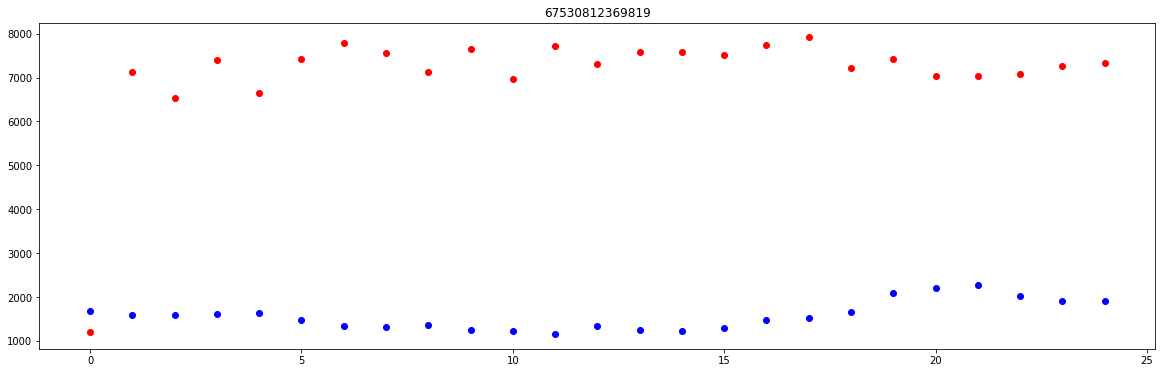

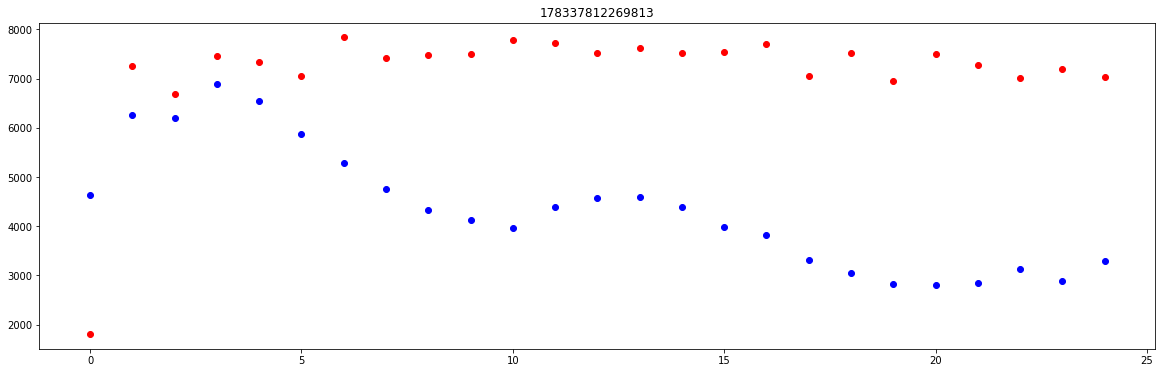

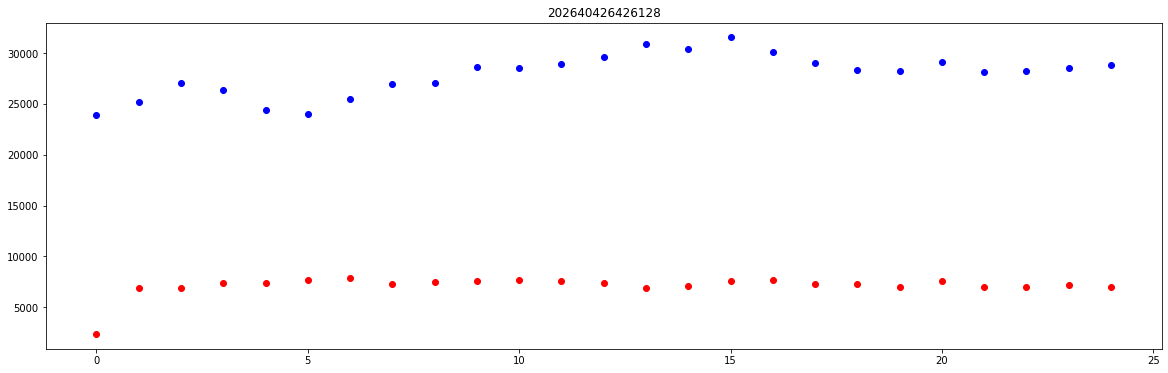

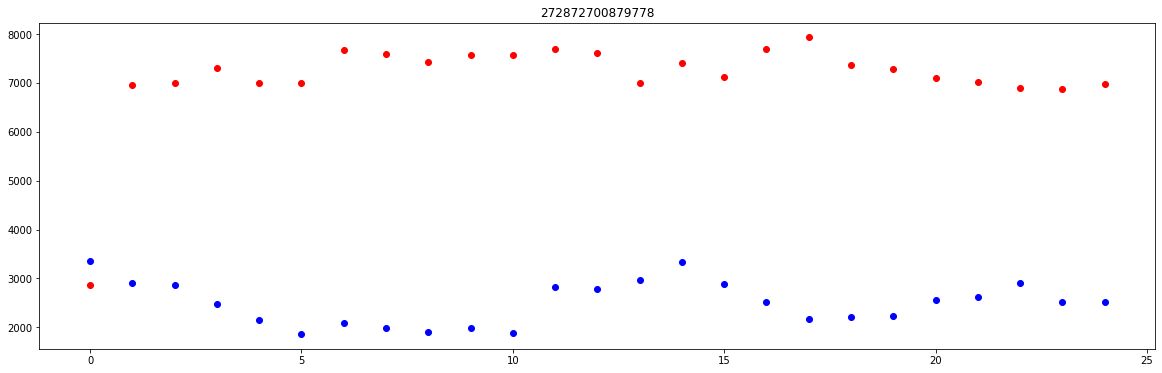

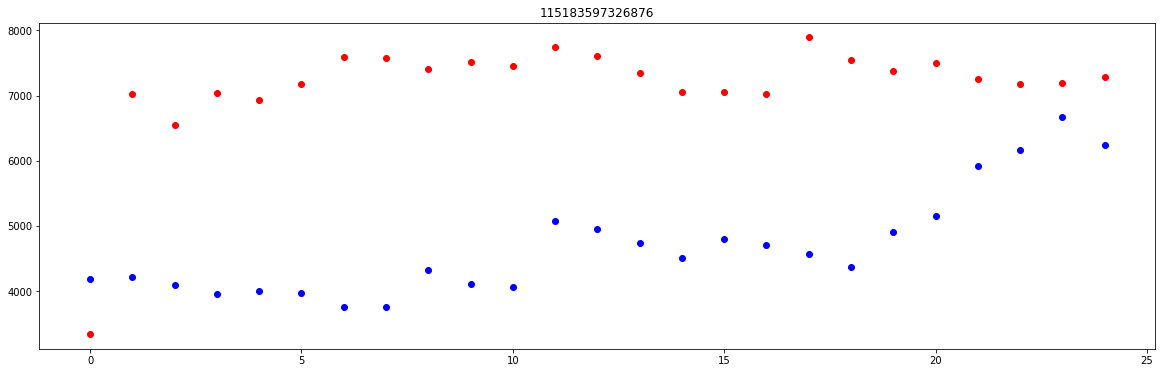

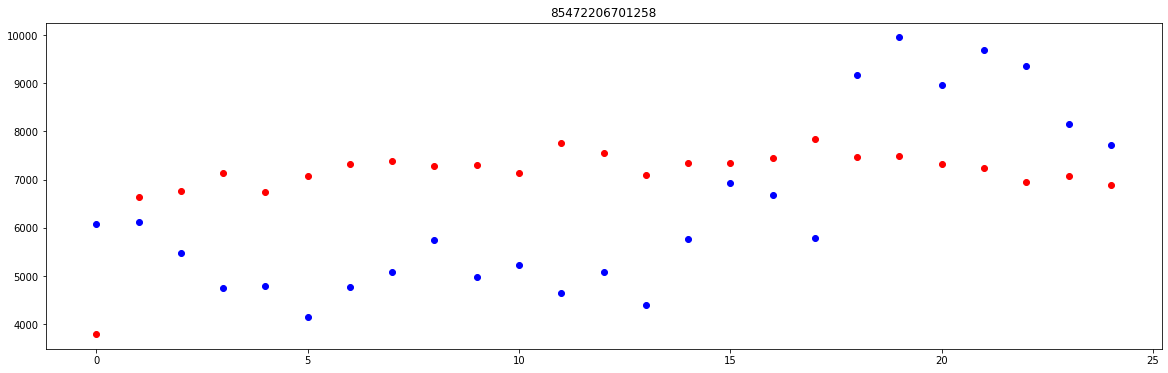

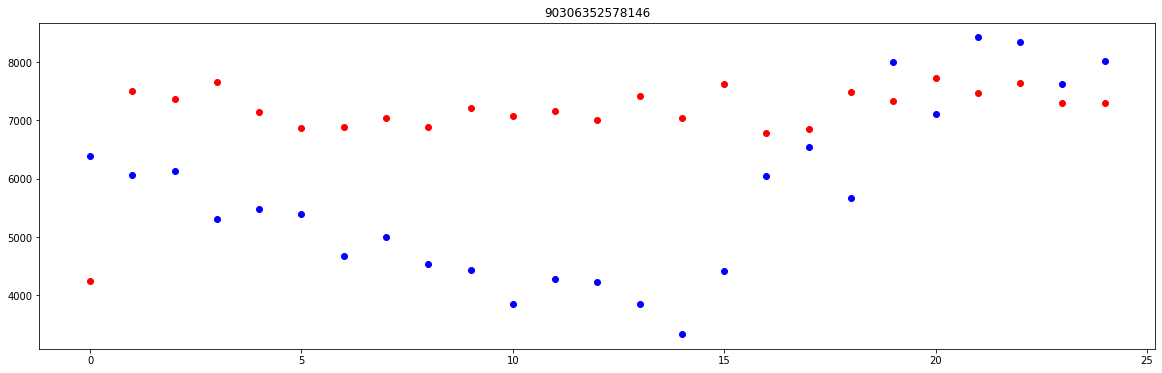

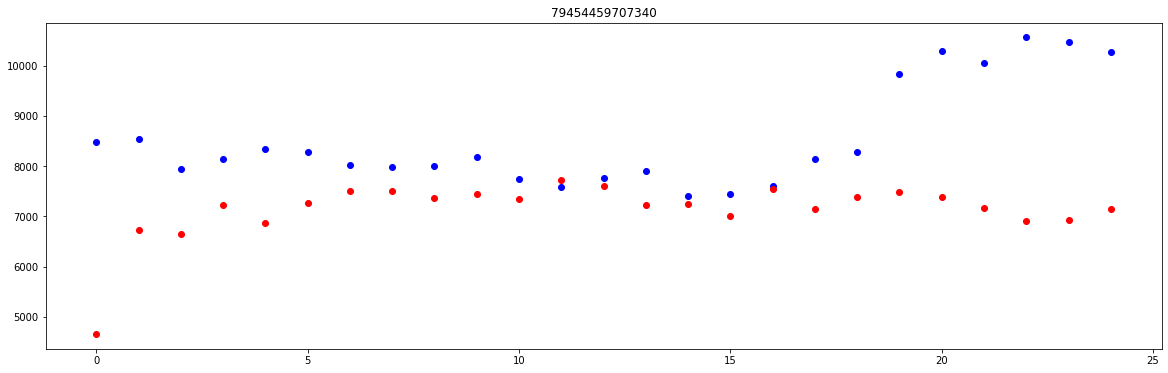

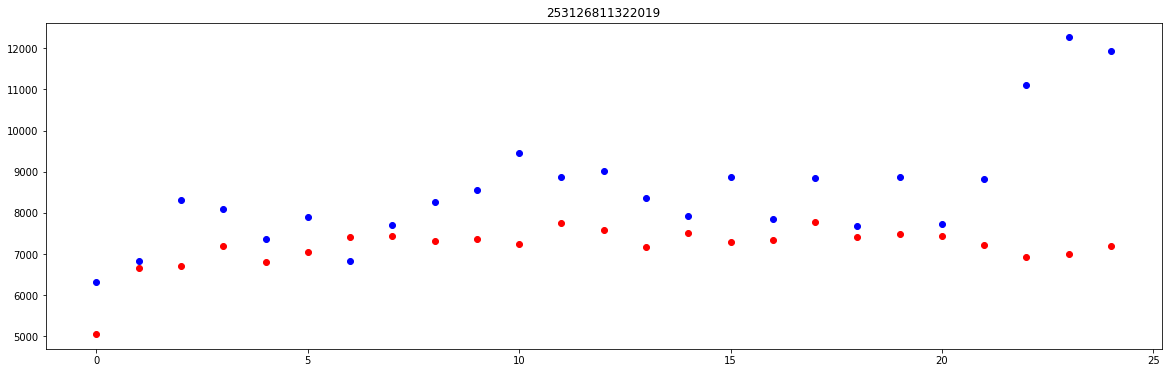

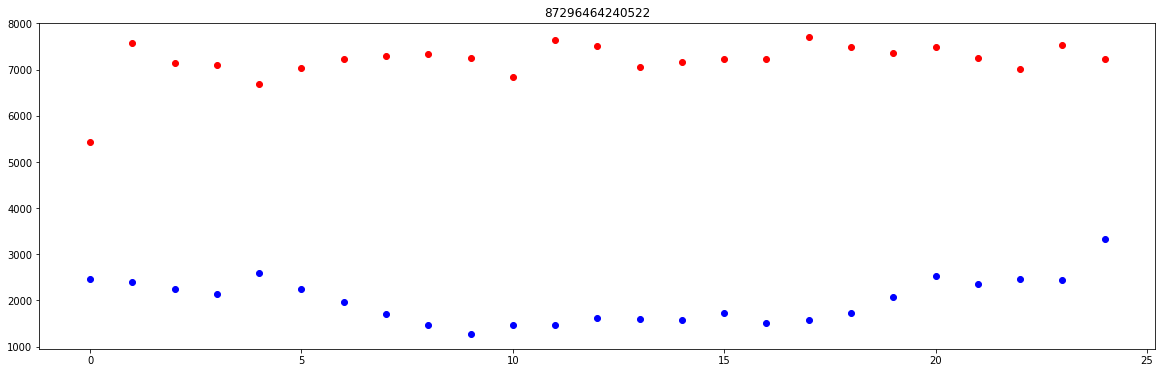

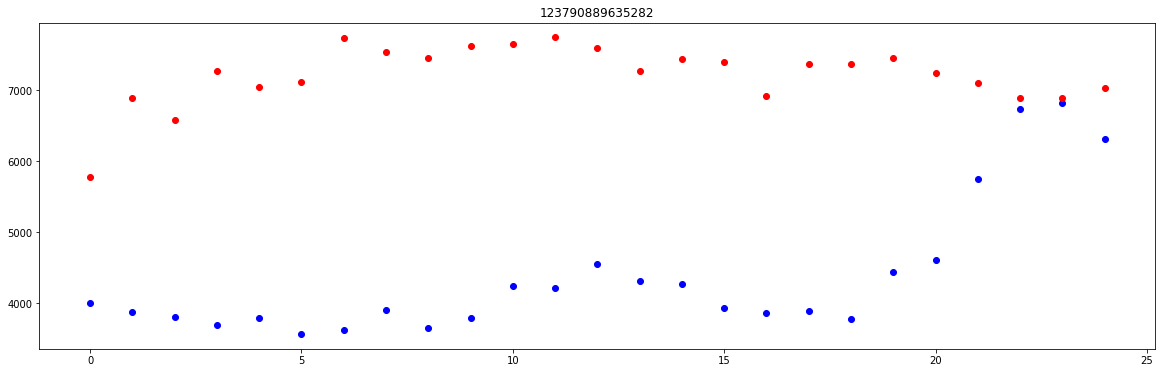

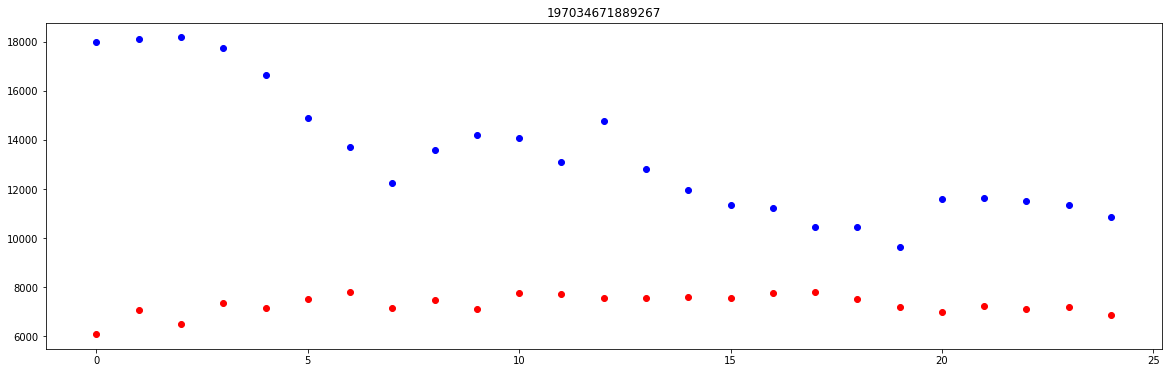

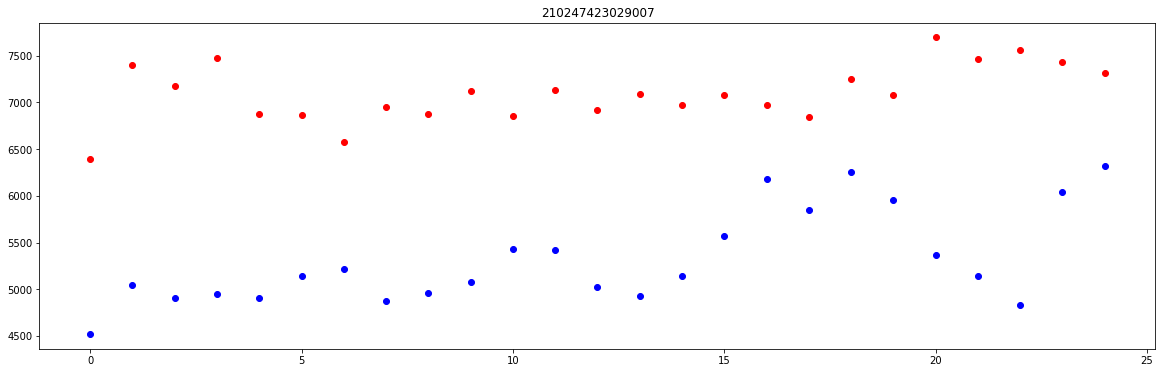

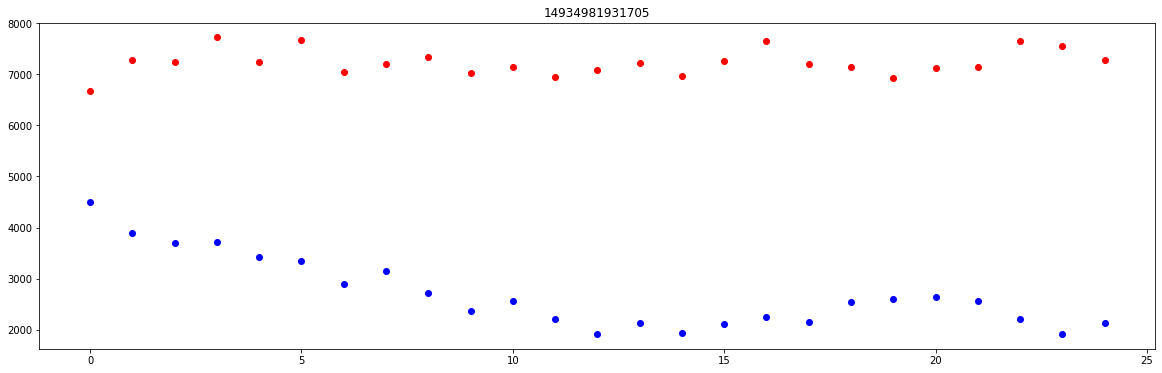

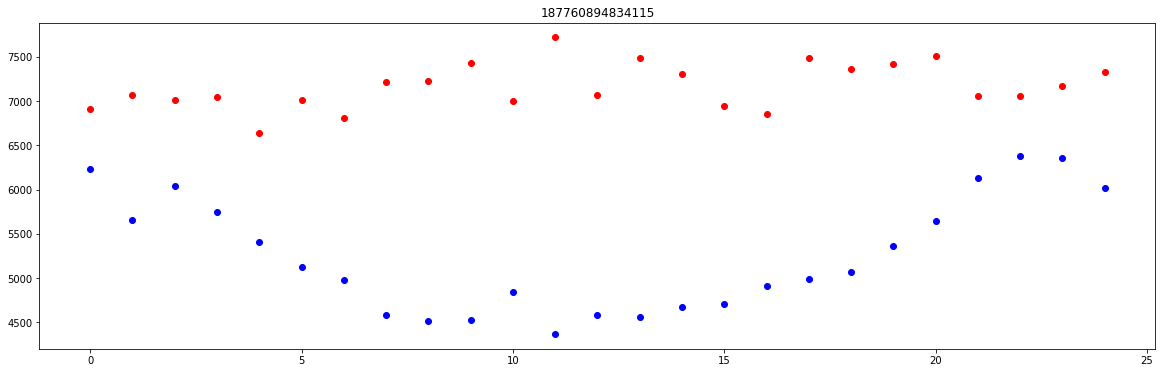

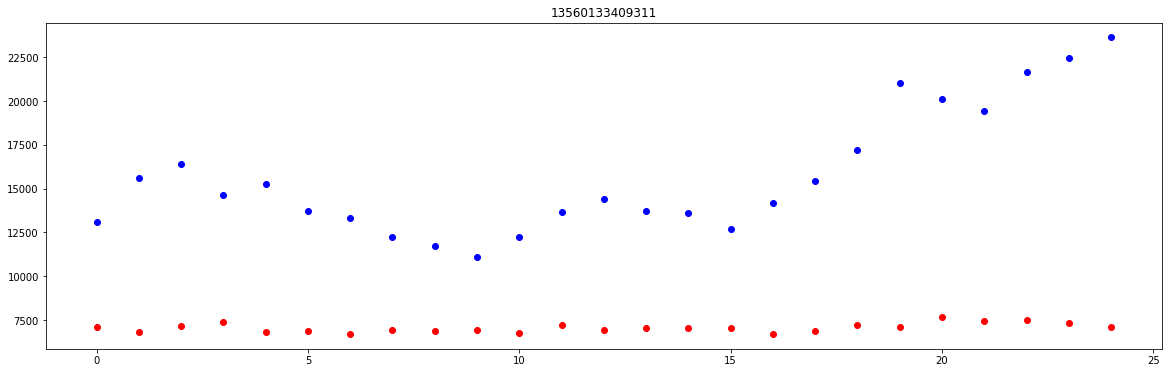

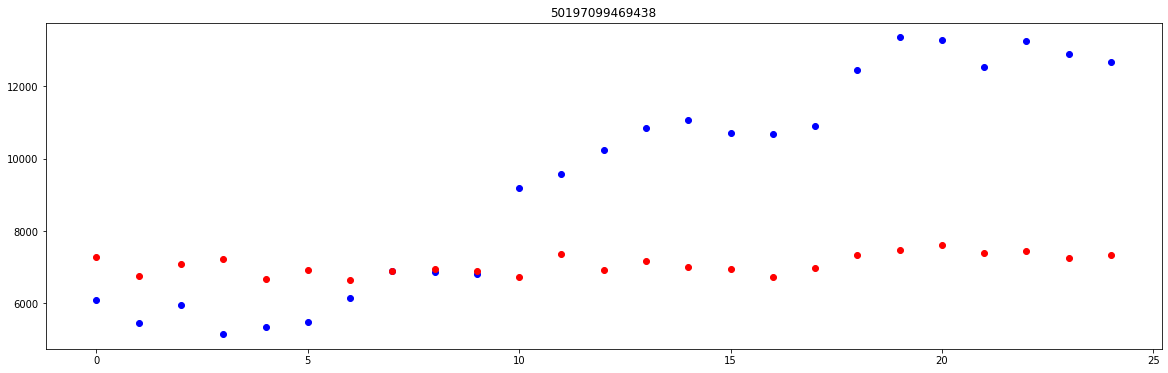

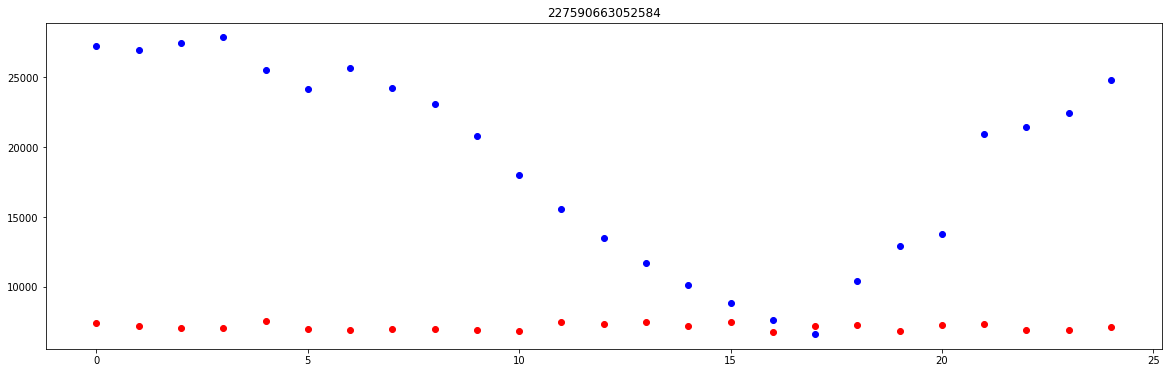

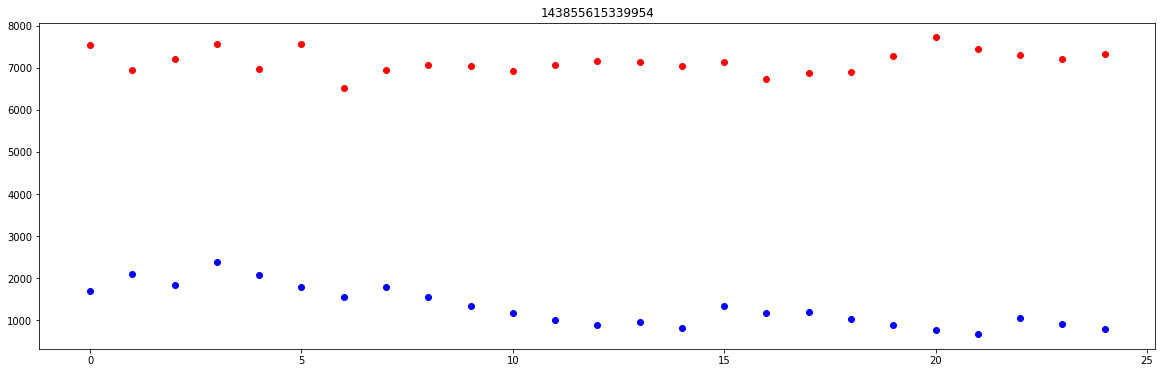

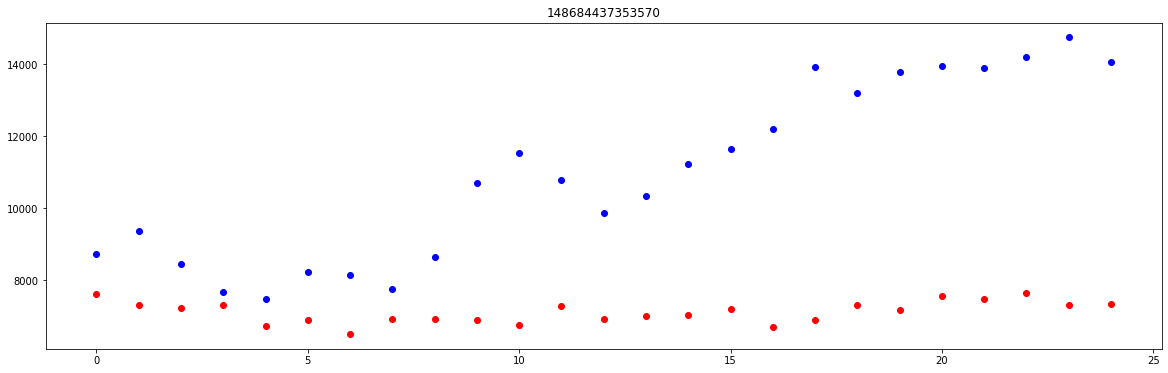

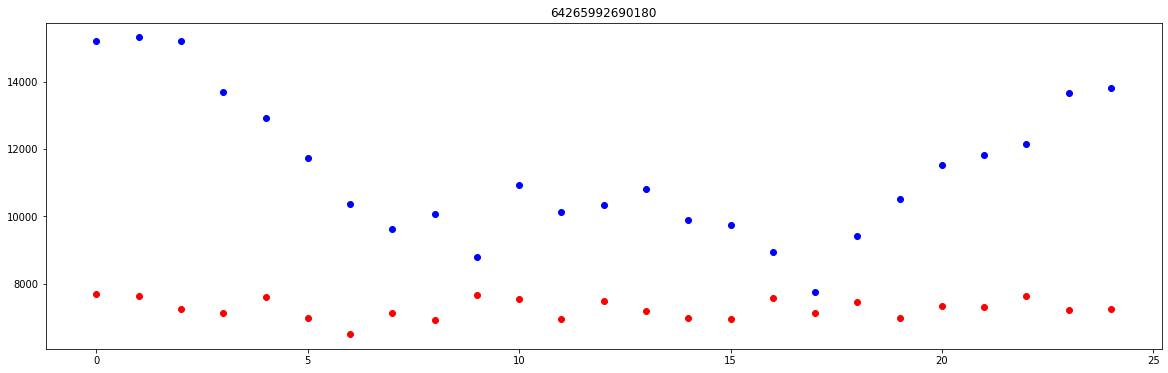

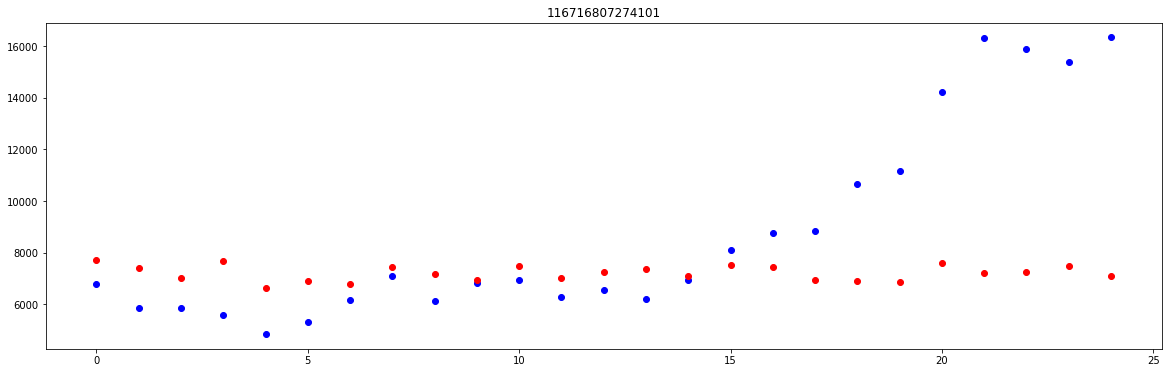

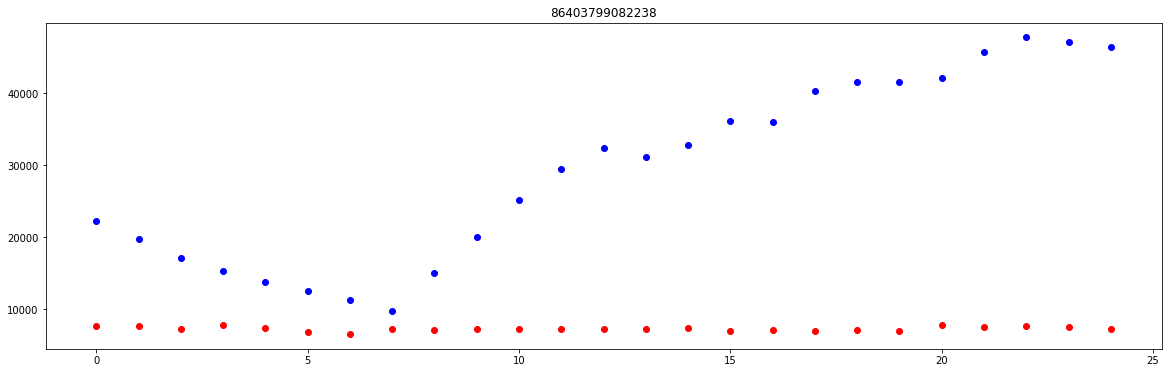

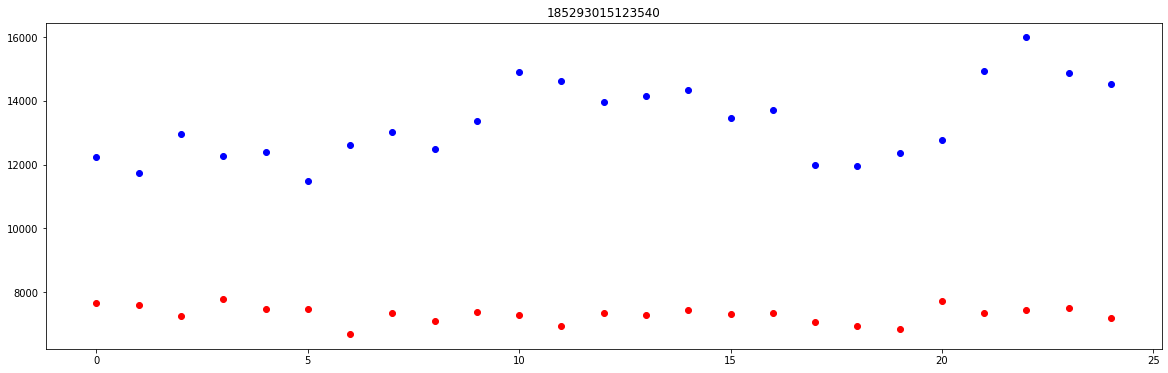

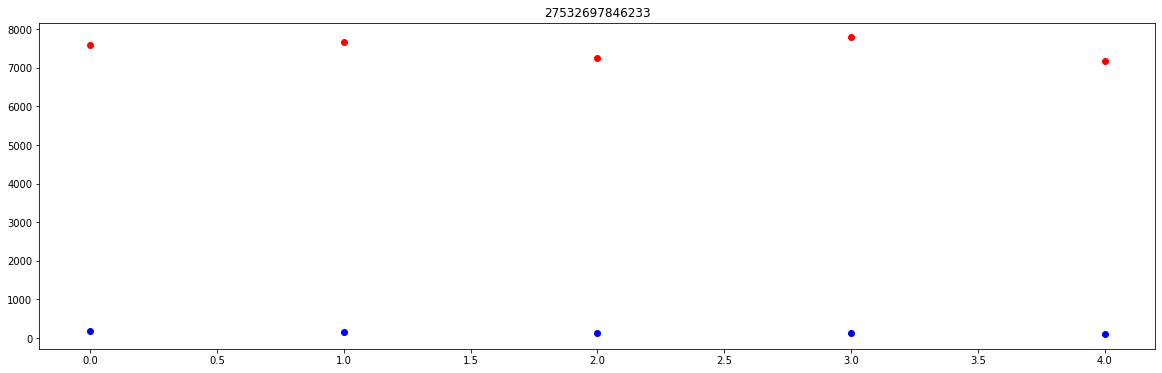

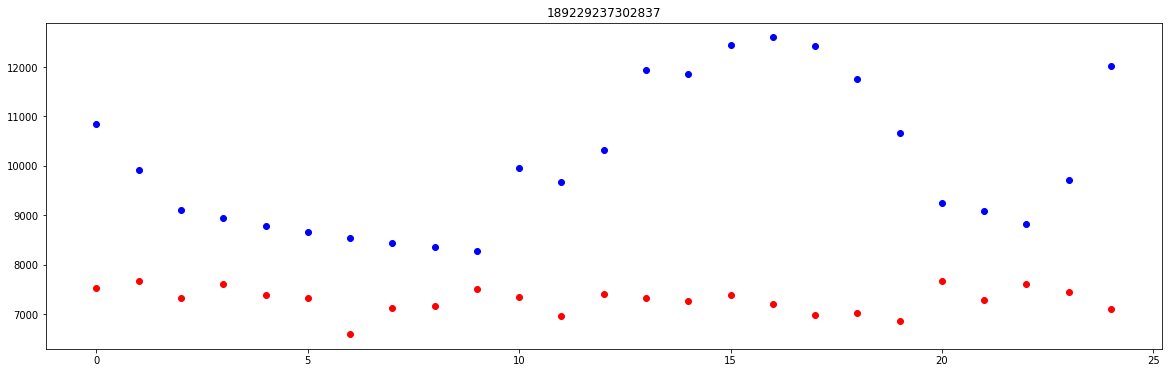

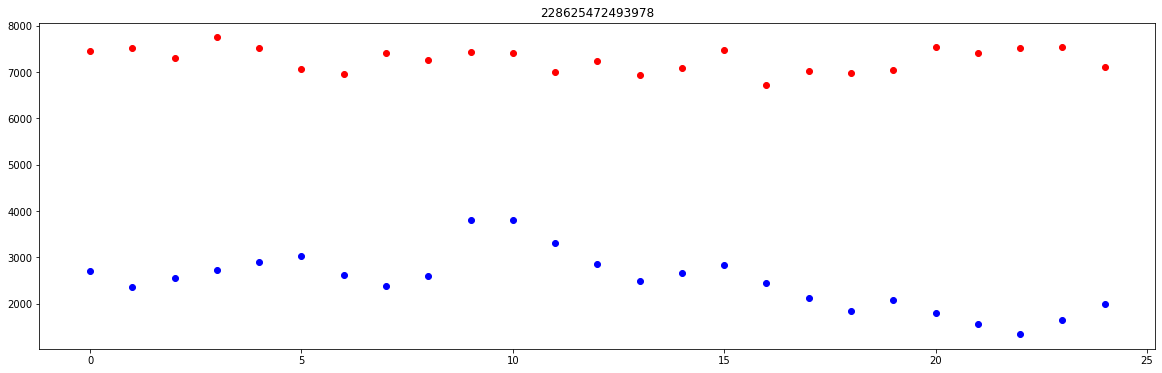

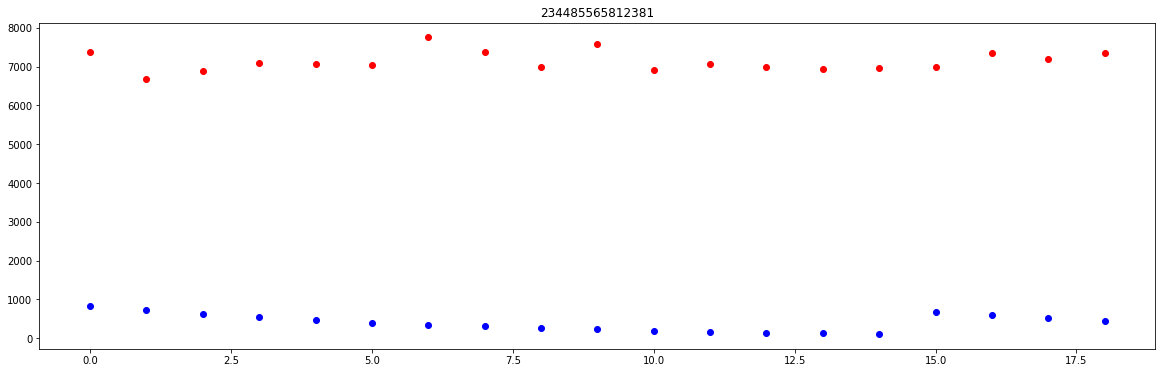

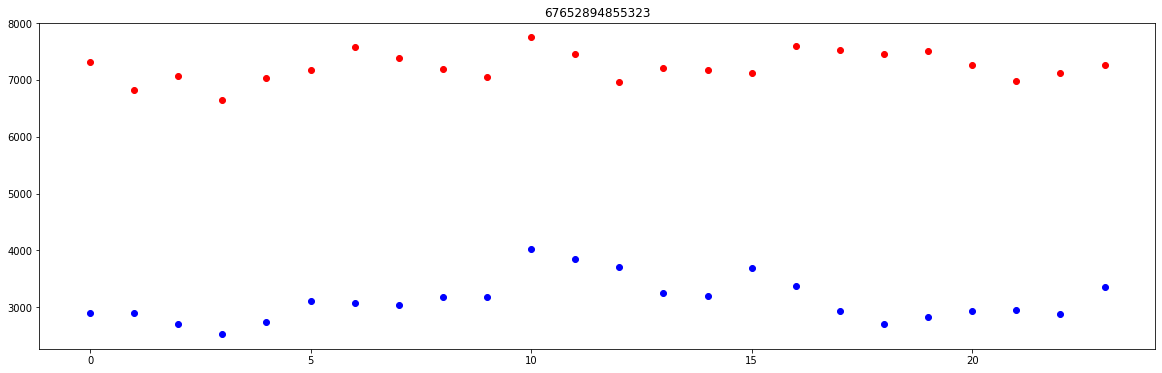

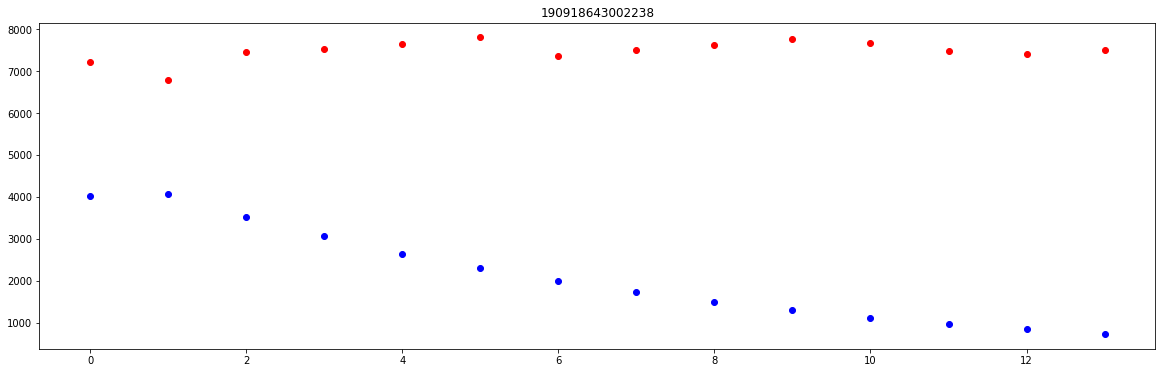

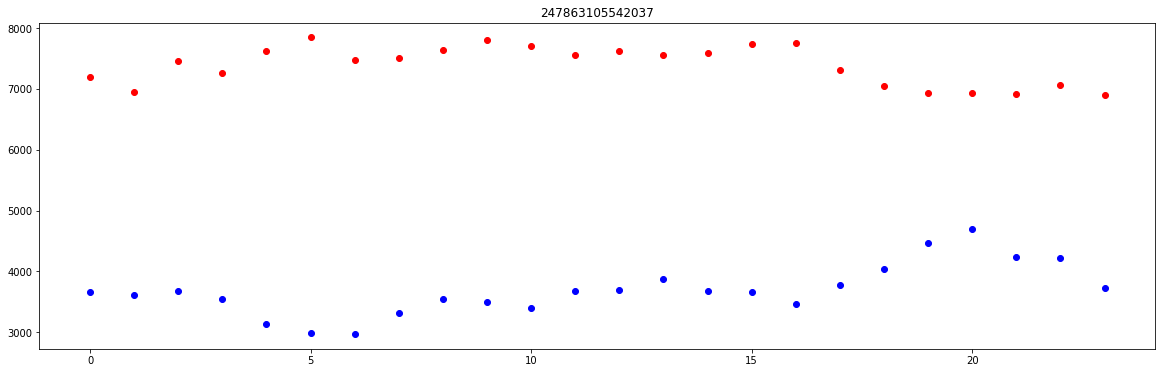

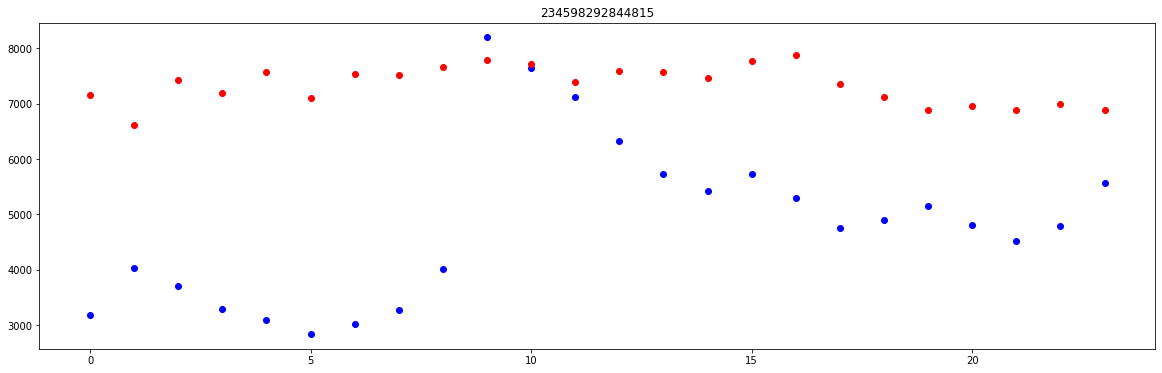

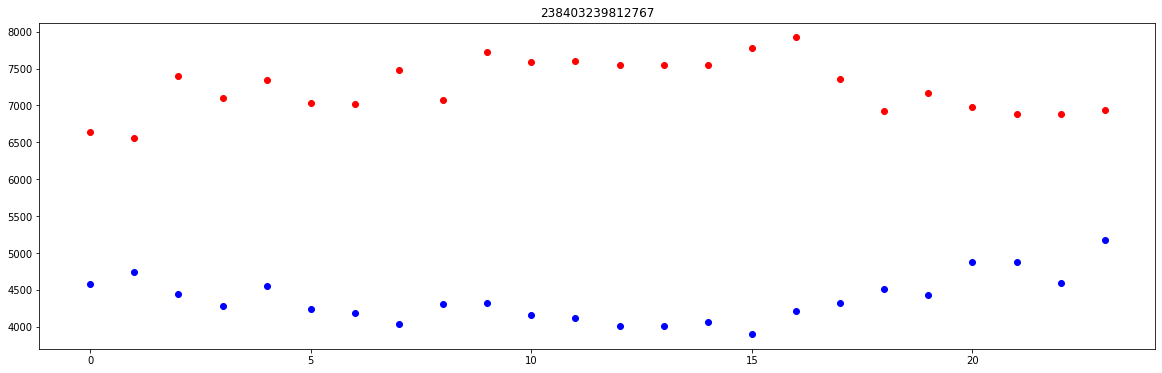

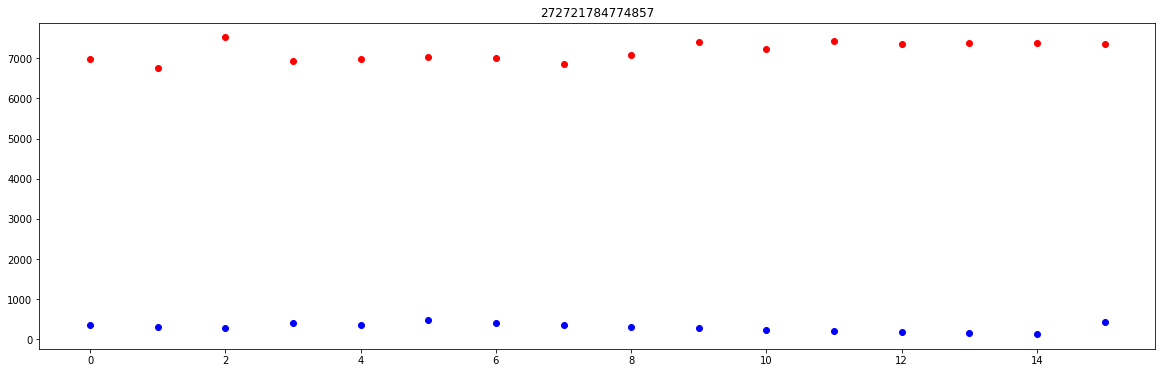

In [85]:
import matplotlib.pyplot as plt
import numpy as np
testing['keywordId'].unique()
for i in range(len(testing['keywordId'].unique())):
    def plotGraph(y_test,y_pred,s):
        if max(y_test) >= max(y_pred):
            my_range = int(max(y_test))
        else:
            my_range = int(max(y_pred))
        plt.scatter(range(len(y_test)), y_test, color='blue')
        plt.scatter(range(len(y_pred)), y_pred, color='red')
        plt.title(s)
        plt.show()
        return
    s = testing['keywordId'].unique()[i]    
    y_sales = testing[testing['keywordId'] == s]['sales']
    y_pred_sales = testing[testing['keywordId'] == s]['pred_sales']
    plotGraph(y_sales, y_pred_sales,s)